In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

import ligo.skymap.plot

from astropy.table import Table, QTable, vstack, join
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

from tqdm import tqdm

from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

# Custom functions / classes
import sys
sys.path.insert(1, '/global/homes/m/mjkeller/DESI_SGA/TF')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust

In [2]:
# cov_tfr, tfr_mcmc_samples, logV0
# w_y3v0p3
temp_infile = open('/global/homes/m/mjkeller/DESI_SGA/TF/Y3/cov_ab_jura_jointTFR_varyV0-perpdwarfs0_z0p1_bgsy3v0p3.pickle', 'rb')
w_y3v0p3_cov_tfr, w_y3v0p3_tfr_mcmc_samples, w_y3v0p3_logV0 = pickle.load(temp_infile)
temp_infile.close()

temp_infile = open('/global/homes/m/mjkeller/DESI_SGA/TF/Y3/cov_ab_jura_jointTFR_varyV0-perpdwarfs0_z0p1_bgsy3wip.pickle', 'rb')
w_y3wip_cov_tfr, w_y3wip_tfr_mcmc_samples, w_y3wip_logV0 = pickle.load(temp_infile)
temp_infile.close()

temp_infile = open('/global/homes/m/mjkeller/DESI_SGA/TF/Y3/cov_ab_jura_jointTFR_varyV0-perpdwarfs0_z0p1_tully.pickle', 'rb')
tully_y3_cov_tfr, tully_y3_tfr_mcmc_samples, tully_y3_logV0 = pickle.load(temp_infile)
temp_infile.close()

temp_infile = open('/global/homes/m/mjkeller/DESI_SGA/TF/Y3/cov_ab_jura_jointTFR_varyV0-perpdwarfs0_z0p1_tempely3.pickle', 'rb')
tempel_y3_cov_tfr, tempel_y3_tfr_mcmc_samples, tempel_y3_logV0 = pickle.load(temp_infile)
temp_infile.close()

-6.641044850284957 [[ -6.5783315   -9.88930894 -13.20055093 -16.51268421 -19.82808271
  -23.1519395  -26.48086106]
 [ -6.48217074  -9.81321865 -13.14392036 -16.47358577 -19.80022899
  -23.11827546 -26.43119273]] [-20.87657727 -20.88566849 -20.85598333 ... -20.87371941 -20.85575993
 -20.86917945]
-6.471718563027162 [[ -6.89666972 -10.10305154 -13.3095276  -16.51636478 -19.72716028
  -22.97523608 -26.23945351]
 [ -6.64051045  -9.9062575  -13.17211701 -16.43724326 -19.69856041
  -22.92240289 -26.13050712]] [-20.16212151 -20.15968809 -20.13911681 ... -20.15982921 -20.1486937
 -20.16920961]
-6.598935923506432 [[ -6.63723481  -9.90484672 -13.17237226 -16.44022615 -19.71184325
  -23.02609148 -26.35772625]
 [ -6.35540451  -9.68875659 -13.02184103 -16.35432886 -19.68238746
  -22.9687851  -26.23773285]] [-20.29509181 -20.29761168 -20.28819758 ... -20.29378499 -20.29499452
 -20.29588885]


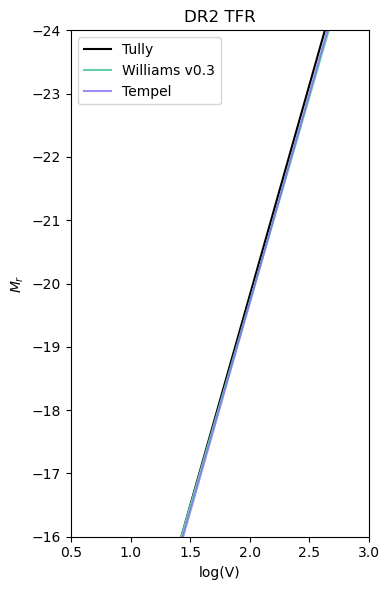

In [3]:
plt.figure(figsize=(4,6), tight_layout=True)
logv = np.arange(0, 3.5, 0.5)

# tully
slope = np.median(tully_y3_tfr_mcmc_samples[0])
ZP = np.median(tully_y3_tfr_mcmc_samples[1])
absmag = slope*(logv - tully_y3_logV0) + ZP

slopes = tully_y3_tfr_mcmc_samples[0]
ZPs = tully_y3_tfr_mcmc_samples[1]

N_samples = len(slopes)

lines = []

for i in range(N_samples):
    lines.append(slopes[i]*(logv - tully_y3_logV0) + ZPs[i])
    
lines_array = np.asarray(lines)
line_err = np.nanpercentile(lines_array, [16 ,84], axis=0)
print(slope, line_err, ZPs)

plt.plot(logv, absmag, 'k', label = 'Tully')
plt.fill_between(logv, line_err[0], line_err[1], color='gainsboro', alpha = .25)

# williams v0.3
slope = np.median(w_y3v0p3_tfr_mcmc_samples[0])
ZP = np.median(w_y3v0p3_tfr_mcmc_samples[1])
absmag = slope*(logv - w_y3v0p3_logV0) + ZP

slopes = w_y3v0p3_tfr_mcmc_samples[0]
ZPs = w_y3v0p3_tfr_mcmc_samples[1]

N_samples = len(slopes)

lines = []

for i in range(N_samples):
    lines.append(slopes[i]*(logv - w_y3v0p3_logV0) + ZPs[i])
    
lines_array = np.asarray(lines)
line_err = np.nanpercentile(lines_array, [16 ,84], axis=0)
print(slope, line_err, ZPs)

plt.plot(logv, absmag, color='mediumaquamarine', label = 'Williams v0.3')
plt.fill_between(logv, line_err[0], line_err[1], color='lightcyan', alpha = .25)

# tempel
slope = np.median(tempel_y3_tfr_mcmc_samples[0])
ZP = np.median(tempel_y3_tfr_mcmc_samples[1])
absmag = slope*(logv - tempel_y3_logV0) + ZP

slopes = tempel_y3_tfr_mcmc_samples[0]
ZPs = tempel_y3_tfr_mcmc_samples[1]

N_samples = len(slopes)

lines = []

for i in range(N_samples):
    lines.append(slopes[i]*(logv - tempel_y3_logV0) + ZPs[i])
    
lines_array = np.asarray(lines)
line_err = np.nanpercentile(lines_array, [16 ,84], axis=0)
print(slope, line_err, ZPs)

plt.plot(logv, absmag, color='mediumslateblue', label = 'Tempel', alpha = .75)
plt.fill_between(logv, line_err[0], line_err[1], color='lavender', alpha = .25)

plt.legend()
plt.title('DR2 TFR')
plt.xlim([0.5, 3])
plt.ylim([-16, -24])
plt.xlabel('log(V)')
plt.ylabel('$M_r$');

In [4]:
# cov_tfr, tfr_mcmc_samples, logV0
# williams y1v0p3
temp_infile = open('/global/homes/m/mjkeller/DESI_SGA/TF/Y1/cov_ab_jura_jointTFR_bgsy1v0p3.pickle', 'rb')
w_y1v0p3_cov_tfr, w_y1v0p3_tfr_mcmc_samples, w_y1v0p3_logV0 = pickle.load(temp_infile)
temp_infile.close()

# tully
temp_infile = open('/global/homes/m/mjkeller/DESI_SGA/TF/Y1/cov_ab_iron_jointTFR_tullyy1.pickle', 'rb')
tully_y1_cov_tfr, tully_y1_tfr_mcmc_samples, tully_y1_logV0 = pickle.load(temp_infile)
temp_infile.close()

# tempel
temp_infile = open('/global/homes/m/mjkeller/DESI_SGA/TF/Y1/cov_ab_jura_jointTFR_tempely1.pickle', 'rb')
tempel_y1_cov_tfr, tempel_y1_tfr_mcmc_samples, tempel_y1_logV0 = pickle.load(temp_infile)
temp_infile.close()

-6.329353836893247 [[ -7.49709611 -10.62912845 -13.76154318 -16.89561347 -20.03658724
  -23.2128802  -26.41041672]
 [ -7.18919386 -10.3912733  -13.59294627 -16.79270462 -19.98449509
  -23.14076301 -26.27693947]] [-21.12032999 -21.08757192 -21.15382131 ... -21.09756451 -21.0943687
 -21.12361602]
-6.906397116288545 [[ -6.42933969  -9.81095304 -13.19290716 -16.57540784 -19.96620059
  -23.44792426 -26.97304413]
 [ -5.79584878  -9.32436995 -12.85290882 -16.38074552 -19.90113495
  -23.33012998 -26.71502396]] [-20.8078179  -20.84916169 -20.81234557 ... -20.85782766 -20.83001025
 -20.81369879]
-7.146562242785209 [[ -5.99437553  -9.47452208 -12.95578588 -16.43819987 -19.93129364
  -23.54353084 -27.20813946]
 [ -5.18839853  -8.85720471 -12.52591294 -16.19301328 -19.85010116
  -23.38820137 -26.87354327]] [-21.03359659 -21.04453968 -20.98246576 ... -21.0569579  -20.99941241
 -21.02555428]


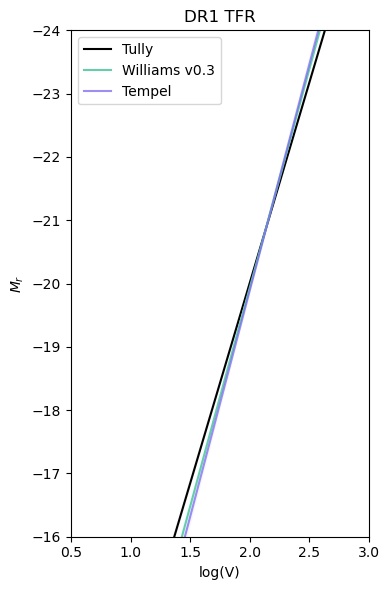

In [5]:
plt.figure(figsize=(4,6), tight_layout=True)
logv = np.arange(0, 3.5, 0.5)

# tully
slope = np.median(tully_y1_tfr_mcmc_samples[0])
ZP = np.median(tully_y1_tfr_mcmc_samples[1])
absmag = slope*(logv - tully_y1_logV0) + ZP

slopes = tully_y1_tfr_mcmc_samples[0]
ZPs = tully_y1_tfr_mcmc_samples[1]

N_samples = len(slopes)

lines = []

for i in range(N_samples):
    lines.append(slopes[i]*(logv - tully_y1_logV0) + ZPs[i])
    
lines_array = np.asarray(lines)
line_err = np.nanpercentile(lines_array, [16 ,84], axis=0)
print(slope, line_err, ZPs)

plt.plot(logv, absmag, 'k', label = 'Tully')
plt.fill_between(logv, line_err[0], line_err[1], color='gainsboro', alpha = .25)

# williams v0.3
slope = np.median(w_y1v0p3_tfr_mcmc_samples[0])
ZP = np.median(w_y1v0p3_tfr_mcmc_samples[1])
absmag = slope*(logv - w_y1v0p3_logV0) + ZP

slopes = w_y1v0p3_tfr_mcmc_samples[0]
ZPs = w_y1v0p3_tfr_mcmc_samples[1]

N_samples = len(slopes)

lines = []

for i in range(N_samples):
    lines.append(slopes[i]*(logv - w_y1v0p3_logV0) + ZPs[i])
    
lines_array = np.asarray(lines)
line_err = np.nanpercentile(lines_array, [16 ,84], axis=0)
print(slope, line_err, ZPs)

plt.plot(logv, absmag, color='mediumaquamarine', label = 'Williams v0.3')
plt.fill_between(logv, line_err[0], line_err[1], color='lightcyan', alpha = .25)

# tempel
slope = np.median(tempel_y1_tfr_mcmc_samples[0])
ZP = np.median(tempel_y1_tfr_mcmc_samples[1])
absmag = slope*(logv - tempel_y1_logV0) + ZP

slopes = tempel_y1_tfr_mcmc_samples[0]
ZPs = tempel_y1_tfr_mcmc_samples[1]

N_samples = len(slopes)

lines = []

for i in range(N_samples):
    lines.append(slopes[i]*(logv - tempel_y1_logV0) + ZPs[i])
    
lines_array = np.asarray(lines)
line_err = np.nanpercentile(lines_array, [16 ,84], axis=0)
print(slope, line_err, ZPs)

plt.plot(logv, absmag, color='mediumslateblue', label = 'Tempel', alpha = .75)
plt.fill_between(logv, line_err[0], line_err[1], color='lavender', alpha = .25)

plt.title('DR1 TFR')
plt.legend()
plt.xlim([0.5, 3])
plt.ylim([-16, -24])
plt.xlabel('log(V)')
plt.ylabel('$M_r$');